# Title

This Notebook...

## Initialization

### Imports

In [121]:
import datetime
import csv
import binascii
import numpy
import scipy
import scipy.ndimage
import scipy.ndimage.measurements
import skimage
import skimage.measure
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

### Helper Functions

In [122]:
debugMode = True;
def dprint(objectToPrint, depth = 0):
    indent = "  " * depth
    if (debugMode):
        print(indent + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")) + " | " + str(objectToPrint))

In [126]:
def extractAttribute(bpsCode, startBit, endBit):
    return int(bpsCode, 16) >> (80 - endBit) & int("1" * (endBit - startBit), 2)

In [145]:
print(extractAttribute("00D00C03405B18200005", 14, 24))
print(extractAttribute("00D00C03405B18200005", 24, 38))

12
208


## Classes

In [278]:
class BPSDetector:
    bpsCode = None
    roadNumber = None
    hectometer = None
    def __init__(self, bpsCode):
        self.bpsCode = bpsCode
        self.roadNumber = extractAttribute(bpsCode, 14, 24)
        self.hectometer = extractAttribute(bpsCode, 24, 38)
    def getBPSCoder(self):
        return self.bpsCode
    def getRoadNumber(self):
        return self.roadNumber
    def getHectometer(self):
        return self.hectometer
    def __str__(self):
        return "bpsCode: {} | roadNumber: {} | hectometer: {}".format(self.bpsCode, self.roadNumber, self.hectometer)

In [279]:
bpsDetector = BPSDetector("00D00C03405B18200005")
print(bpsDetector)

bpsCode: 00D00C03405B18200005 | roadNumber: 12 | hectometer: 208


In [285]:
class Road:
    roadNumber = None
    bpsDetectors = set()
    spaceToSpaceIndex = dict()
    def __init__(self, roadNumber):
        self.roadNumber = roadNumber
    def addBPSDetector(self, bpsDetector):
        self.bpsDetectors.add(bpsDetector)
    def indexDetectorSpaces(self):
        spaceSet = set()
        for bpsDetector in self.bpsDetectors:
            spaceSet.add(bpsDetector.getHectometer())
        sortedSpaceSet = sorted(spaceSet)
        for spaceIndex in range(len(sortedSpaceSet)):
            self.spaceToSpaceIndex.update({sortedSpaceSet[spaceIndex]:spaceIndex})
    def getSpaceToSpaceIndex(self):
        return self.spaceToSpaceIndex
    def __str__(self):
        return "roadNumber: {} | len(bpsDetectors): {}".format(self.roadNumber, len(self.bpsDetectors))

In [286]:
road = Road(15)
road.addBPSDetector(bpsDetector)
road.indexDetectorSpaces()
print(road)
road.getSpaceToSpaceIndex()

roadNumber: 15 | len(bpsDetectors): 1


{208: 0}

## Roads

In [287]:
def readCSVToBPSCodes(fileName):
    result = []
    with open(fileName, "r") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row[3] == "R":
                result.append(row[0])
    return result

In [288]:
bpsCodes = readCSVToBPSCodes("resources\Test_Data\BPS_20171120.csv")

In [296]:
for bpsCode in bpsCodes:
    print(bpsCode)

10D00100A055D0070007
10D00100A055D007000B
10D00100A055D007000F
10D00100B85ED0070007
10D00100B85ED007000B
10D00100B85ED007000F
10D00100D05CD0070007
10D00100D05CD007000B
10D00100D05CD007000F
10D00100D05CD0070013
10D00100D05CD0070017
10D00100DC02D0070007
10D00100DC02D007000B
10D00100DC02D007000F
10D00100DC02D0070013
10D00100DC02D0070017
10D00100F41AD0070007
10D00100F41AD007000B
10D00100F41AD007000F
10D00100F41AD0070013
10D001010049D0070007
10D001010049D007000B
10D001010049D007000F
10D001010049D0070013
10D001011805D0070007
10D001011805D007000B
10D001011805D007000F
10D001011805D0070013
10D001011C62D007000B
10D001011C62D007000F
10D001011C62D0070013
10D001011C62D0070017
10D001012C00D0070007
10D001012C00D007000B
10D001012C00D007000F
10D001012C00D0070013
10D001012C00D0070307
10D001012C00D007030B
10D001013800D0070007
10D001013800D007000B
10D001013800D007000F
10D001013800D0070013
10D001013800D0070307
10D001013800D007030B
10D001014063D0070007
10D001014063D007000B
10D001014063D007000F
10D001014063D

10D00227DC0CD0070007
10D00227E021D0070007
10D00227E021D007000B
10D00227E04FD0070007
10D00227E43CD0070007
10D00227E43CD007000B
10D00227E827D0070007
10D00227E827D0070107
10D00227EC0DD0070007
10D00227EC0DD007000B
10D00227F007D0070007
10D00227F007D0070307
10D00227F040D0070007
10D00227F040D007000B
10D00227F445D0070007
10D00227F445D0070307
10D00227F80DD0070007
10D00227F80DD007000B
10D00227FC25D0070007
10D00227FC25D0070307
10D00227FC3DD0070007
10D00227FC3DD007000B
10D002280054D0070007
10D002280054D0070307
10D00228040ED0070007
10D00228040ED007000B
10D002280821D0070007
10D002280821D0070307
10D00228083DD0070007
10D00228083DD007000B
10D002280C3AD0070007
10D002280C3AD0070307
10D00228100BD0070007
10D00228100BD007000B
10D002281403D0070007
10D002281403D0070307
10D002281440D0070007
10D002281440D007000B
10D00228183AD0070007
10D00228183AD0070307
10D002281C0DD0070007
10D002281C0DD007000B
10D002281C53D0070007
10D002281C53D0070307
10D002282040D0070007
10D002282040D007000B
10D002282428D0070007
10D002282428D

10D00E023407D0070007
10D00E023407D007000B
10D00E023839D0070007
10D00E023839D007000B
10D00E024007D0070007
10D00E024007D007000B
10D00E02443AD0070007
10D00E02443AD007000B
10D00E024C32D0070007
10D00E024C32D007000B
10D00F033841D0070007
10D00F033841D007000B
10D00F034C00D0070007
10D00F034C00D007000B
10D00F035C0AD0070007
10D00F035C0AD007000B
10D00F03645FD0070007
10D00F03645FD007000B
10D00F03645FD0070107
10D00F03740AD0070007
10D00F03740AD007000B
10D00F038014D0070007
10D00F038014D007000B
10D00F03940AD0070007
10D00F03940AD007000B
10D00F039C4BD0070007
10D00F039C4BD007000B
10D00F03B00AD0070007
10D00F03B00AD007000B
10D00F03C80AD0070007
10D00F03C80AD007000B
10D00F03D432D0070007
10D00F03D432D007000B
10D00F03E40AD0070007
10D00F03E40AD007000B
10D00F03F40AD0070007
10D00F03F40AD007000B
10D00F040432D0070007
10D00F040432D007000B
10D00F041050D0070007
10D00F041050D007000B
10D00F041C32D0070007
10D00F041C32D007000B
10D00F041C32D0070107
10D00F05181AD0070007
10D00F05181AD007000B
10D00F053042D0070007
10D00F053042D

10D043058850D007000B
10D043059828D0070007
10D043059828D007000B
10D04305A805D0070007
10D04305A805D007000B
10D04305B04BD0070007
10D04305B04BD007000B
10D04305C005D0070007
10D04305C005D007000B
10D04305C837D0070007
10D04305C837D007000B
10D04305D832D0070007
10D04305D832D007000B
10D04305E407D0070007
10D04305E407D007000B
10D04305F450D0070007
10D04305F450D007000B
10D043061000D0070007
10D043061000D007000B
10D04900D014D0070007
10D04900D014D007000B
10D04900E046D0070007
10D04900E046D007000B
10D04900F050D0070007
10D04900F050D007000B
10D049104828D0070007
10D049104828D007000B
10D049104828D0070187
10D049105000D0070007
10D049105000D007000B
10D049105000D0070187
10D049105828D0070007
10D049105828D007000B
10D049105828D0070187
10D04910645AD0070007
10D04910645AD007000B
10D04910645AD0070187
10D04911A81ED0070007
10D04911A81ED007000B
10D04911A81ED0070187
10D04911C014D0070007
10D04911C014D0070087
10D04911C014D007008B
10D04911C014D0070187
10D04911CC0AD0070007
10D04911CC0AD0070087
10D04911CC0AD007008B
10D04911CC0AD

In [300]:
def parseBPSCodesToRoads(bpsCodes):
    result = dict()
    for bpsCode in bpsCodes:
        bpsDetector = BPSDetector(bpsCode)
        roadNumber = bpsDetector.getRoadNumber()
        if roadNumber not in result:
            result.update({roadNumber:Road(roadNumber)})
        result[roadNumber].addBPSDetector(bpsDetector)
    #for key, value in result.items():
        #value.indexDetectorSpaces()
    return result

In [301]:
roads = parseBPSCodesToRoads(bpsCodes)

In [302]:
for key, value in roads.items():
    print(value)

roadNumber: 1 | len(bpsDetectors): 33693
roadNumber: 2 | len(bpsDetectors): 33693
roadNumber: 4 | len(bpsDetectors): 33693
roadNumber: 5 | len(bpsDetectors): 33693
roadNumber: 6 | len(bpsDetectors): 33693
roadNumber: 7 | len(bpsDetectors): 33693
roadNumber: 8 | len(bpsDetectors): 33693
roadNumber: 9 | len(bpsDetectors): 33693
roadNumber: 10 | len(bpsDetectors): 33693
roadNumber: 11 | len(bpsDetectors): 33693
roadNumber: 12 | len(bpsDetectors): 33693
roadNumber: 13 | len(bpsDetectors): 33693
roadNumber: 14 | len(bpsDetectors): 33693
roadNumber: 15 | len(bpsDetectors): 33693
roadNumber: 16 | len(bpsDetectors): 33693
roadNumber: 20 | len(bpsDetectors): 33693
roadNumber: 22 | len(bpsDetectors): 33693
roadNumber: 27 | len(bpsDetectors): 33693
roadNumber: 28 | len(bpsDetectors): 33693
roadNumber: 29 | len(bpsDetectors): 33693
roadNumber: 30 | len(bpsDetectors): 33693
roadNumber: 32 | len(bpsDetectors): 33693
roadNumber: 35 | len(bpsDetectors): 33693
roadNumber: 38 | len(bpsDetectors): 33693


## Speed and Flows

In [6]:
testDataArray = numpy.random.rand(16,9)
print(testDataArray >= 0.9)

[[False False False False False False False False False]
 [False False False False False False False False False]
 [ True False False False False False False False False]
 [False False False False False False False  True False]
 [False False False False  True False False False False]
 [ True False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [ True False  True False False  True False False False]
 [False False False False  True False False False False]
 [False False False False False False False False False]
 [False False False False False False False False  True]
 [False False False  True False False False  True False]
 [False False  True False False False False False False]
 [False False False False False False False False False]
 [False False False  True False False False False False]]


In [7]:
def addBoundaries(ax, boundaries):
    rect = patches.Rectangle((
        boundaries[2] - 0.5,
        boundaries[0] - 0.5),
        boundaries[3] - boundaries[2] + 1,
        boundaries[1] - boundaries[0] + 1,
        linewidth = 1,
        edgecolor = "r",
        hatch = "//",
        facecolor = "none")
    ax.add_patch(rect)

In [34]:
def showDataWithBoundaries(dataArray, boundariesList):
    fig, ax = plt.subplots(1)
    ax.imshow(dataArray, aspect = "auto")
    for i in range(len(boundariesList)):
        addBoundaries(ax, boundariesList[i])
    plt.show()

In [35]:
def scan(dataArray, boundaries = None, threshold = 1, depth = 0):
    dprint("Starting scan...", depth)
    if boundaries is None:
        boundaries = [0, dataArray.shape[0] - 1, 0, dataArray.shape[1] - 1]
    boundariesList = []
    subArray = dataArray[boundaries[0]:boundaries[1] + 1, boundaries[2]:boundaries[3] + 1]
    arrayBoolean = numpy.any(subArray < threshold, depth % 2)
    if depth % 2:
        length = boundaries[1] + 1 - boundaries[0]
    else:
        length = boundaries[3] + 1 - boundaries[2]
    started = False
    if length > 1:
        childBoundaries = boundaries[:]
        for i in range(length):
            if arrayBoolean[i] and not started:
                dprint("Found start: " + str(i), depth)
                if depth % 2:
                    childBoundaries[0] = boundaries[0] + i
                else:
                    childBoundaries[2] = boundaries[2] + i
                started = True
            elif not arrayBoolean[i] and started:
                dprint("Found stop: " + str(i - 1), depth)
                if depth % 2:
                    childBoundaries[1] = boundaries[0] + i - 1
                else:
                    childBoundaries[3] = boundaries[2] + i - 1
                started = False
                boundariesList.append(childBoundaries[:])
        if started:
            dprint("Found stop at end.", depth)
            if depth % 2:
                childBoundaries[1] = boundaries[1]
            else:
                childBoundaries[3] = boundaries[3]
            boundariesList.append(childBoundaries)
    else:
        dprint("Length is one", depth)
        boundariesList.append(boundaries)
    dprint("Ending scan...", depth)
    return boundariesList

In [36]:
scan(testDataArray, threshold = 0.1, depth = 0)

2017-11-27 15:29:06 | Starting scan...
2017-11-27 15:29:06 | Found start: 0
2017-11-27 15:29:06 | Found stop: 6
2017-11-27 15:29:06 | Found start: 8
2017-11-27 15:29:06 | Found stop at end.
2017-11-27 15:29:06 | Ending scan...


[[0, 15, 0, 6], [0, 15, 8, 8]]

In [37]:
def recursiveScan(dataArray, boundaries = None, depth = 0, parentLength = 0, threshold = 1): # Remove copies?
    dprint("Starting recursiveScan...", depth)
    dprint("Direction: " + str(depth % 2), depth)
    result = []
    boundariesList = scan(dataArray, boundaries, threshold, depth)
    showDataWithBoundaries(dataArray, boundariesList)
    length = len(boundariesList)
    dprint("length: " + str(length), depth)
    dprint("parentLength: " + str(parentLength), depth)
    if length == 0:
        dprint("Error: nothing found...", depth) # Throw Exception?
    elif length == 1 and parentLength == 1:
        dprint("Done: " + str(boundariesList[0]))
        return boundariesList
    else:
        dprint("Scanning children...", depth)
        parentLength = length;
        childDepth = depth + 1;
        for i in range(length):
            dprint("Child: " + str(i), depth)
            childBoundaries = boundariesList[i][:]
            result += recursiveScan(dataArray, childBoundaries, childDepth, parentLength, threshold)
    return result
    dprint("Ending recursiveScan...", depth)

2017-11-27 15:29:08 | Starting recursiveScan...
2017-11-27 15:29:08 | Direction: 0
2017-11-27 15:29:08 | Starting scan...
2017-11-27 15:29:08 | Found start: 0
2017-11-27 15:29:08 | Found stop: 6
2017-11-27 15:29:08 | Found start: 8
2017-11-27 15:29:08 | Found stop at end.
2017-11-27 15:29:08 | Ending scan...


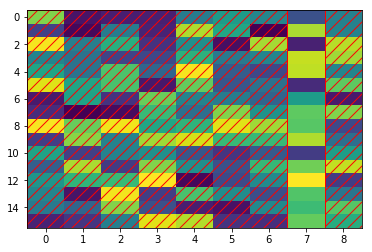

2017-11-27 15:29:08 | length: 2
2017-11-27 15:29:08 | parentLength: 0
2017-11-27 15:29:08 | Scanning children...
2017-11-27 15:29:08 | Child: 0
  2017-11-27 15:29:08 | Starting recursiveScan...
  2017-11-27 15:29:08 | Direction: 1
  2017-11-27 15:29:08 | Starting scan...
  2017-11-27 15:29:08 | Found start: 0
  2017-11-27 15:29:08 | Found stop: 2
  2017-11-27 15:29:08 | Found start: 5
  2017-11-27 15:29:08 | Found stop: 7
  2017-11-27 15:29:08 | Found start: 12
  2017-11-27 15:29:08 | Found stop: 14
  2017-11-27 15:29:08 | Ending scan...


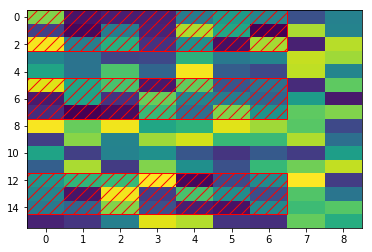

  2017-11-27 15:29:08 | length: 3
  2017-11-27 15:29:08 | parentLength: 2
  2017-11-27 15:29:08 | Scanning children...
  2017-11-27 15:29:08 | Child: 0
    2017-11-27 15:29:08 | Starting recursiveScan...
    2017-11-27 15:29:08 | Direction: 0
    2017-11-27 15:29:08 | Starting scan...
    2017-11-27 15:29:08 | Found start: 1
    2017-11-27 15:29:08 | Found stop: 2
    2017-11-27 15:29:08 | Found start: 5
    2017-11-27 15:29:08 | Found stop at end.
    2017-11-27 15:29:08 | Ending scan...


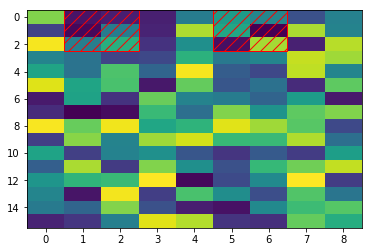

    2017-11-27 15:29:08 | length: 2
    2017-11-27 15:29:08 | parentLength: 3
    2017-11-27 15:29:08 | Scanning children...
    2017-11-27 15:29:08 | Child: 0
      2017-11-27 15:29:08 | Starting recursiveScan...
      2017-11-27 15:29:08 | Direction: 1
      2017-11-27 15:29:08 | Starting scan...
      2017-11-27 15:29:08 | Found start: 0
      2017-11-27 15:29:08 | Found stop: 1
      2017-11-27 15:29:08 | Ending scan...


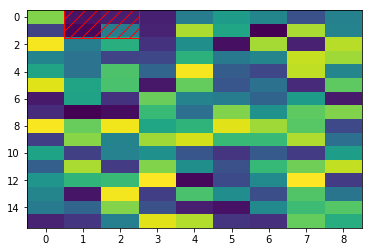

      2017-11-27 15:29:08 | length: 1
      2017-11-27 15:29:08 | parentLength: 2
      2017-11-27 15:29:08 | Scanning children...
      2017-11-27 15:29:08 | Child: 0
        2017-11-27 15:29:08 | Starting recursiveScan...
        2017-11-27 15:29:08 | Direction: 0
        2017-11-27 15:29:08 | Starting scan...
        2017-11-27 15:29:08 | Found start: 0
        2017-11-27 15:29:08 | Found stop at end.
        2017-11-27 15:29:08 | Ending scan...


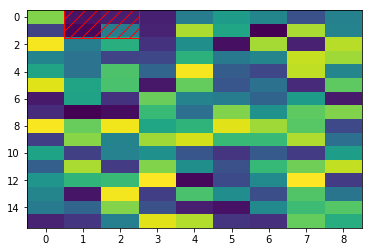

        2017-11-27 15:29:09 | length: 1
        2017-11-27 15:29:09 | parentLength: 1
2017-11-27 15:29:09 | Done: [0, 1, 1, 2]
    2017-11-27 15:29:09 | Child: 1
      2017-11-27 15:29:09 | Starting recursiveScan...
      2017-11-27 15:29:09 | Direction: 1
      2017-11-27 15:29:09 | Starting scan...
      2017-11-27 15:29:09 | Found start: 1
      2017-11-27 15:29:09 | Found stop at end.
      2017-11-27 15:29:09 | Ending scan...


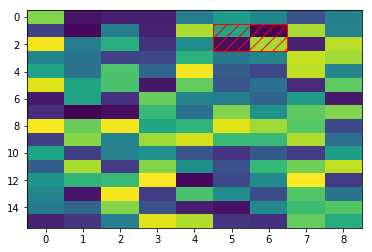

      2017-11-27 15:29:09 | length: 1
      2017-11-27 15:29:09 | parentLength: 2
      2017-11-27 15:29:09 | Scanning children...
      2017-11-27 15:29:09 | Child: 0
        2017-11-27 15:29:09 | Starting recursiveScan...
        2017-11-27 15:29:09 | Direction: 0
        2017-11-27 15:29:09 | Starting scan...
        2017-11-27 15:29:09 | Found start: 0
        2017-11-27 15:29:09 | Found stop at end.
        2017-11-27 15:29:09 | Ending scan...


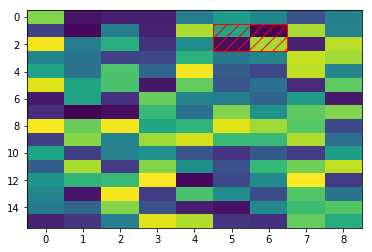

        2017-11-27 15:29:09 | length: 1
        2017-11-27 15:29:09 | parentLength: 1
2017-11-27 15:29:09 | Done: [1, 2, 5, 6]
  2017-11-27 15:29:09 | Child: 1
    2017-11-27 15:29:09 | Starting recursiveScan...
    2017-11-27 15:29:09 | Direction: 0
    2017-11-27 15:29:09 | Starting scan...
    2017-11-27 15:29:09 | Found start: 0
    2017-11-27 15:29:09 | Found stop: 3
    2017-11-27 15:29:09 | Ending scan...


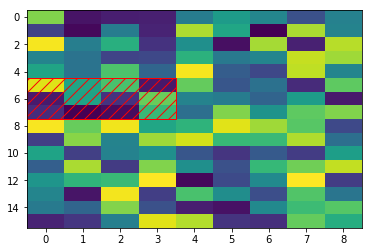

    2017-11-27 15:29:09 | length: 1
    2017-11-27 15:29:09 | parentLength: 3
    2017-11-27 15:29:09 | Scanning children...
    2017-11-27 15:29:09 | Child: 0
      2017-11-27 15:29:09 | Starting recursiveScan...
      2017-11-27 15:29:09 | Direction: 1
      2017-11-27 15:29:09 | Starting scan...
      2017-11-27 15:29:09 | Found start: 0
      2017-11-27 15:29:09 | Found stop at end.
      2017-11-27 15:29:09 | Ending scan...


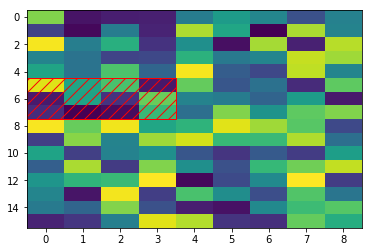

      2017-11-27 15:29:09 | length: 1
      2017-11-27 15:29:09 | parentLength: 1
2017-11-27 15:29:09 | Done: [5, 7, 0, 3]
  2017-11-27 15:29:09 | Child: 2
    2017-11-27 15:29:09 | Starting recursiveScan...
    2017-11-27 15:29:09 | Direction: 0
    2017-11-27 15:29:09 | Starting scan...
    2017-11-27 15:29:09 | Found start: 1
    2017-11-27 15:29:09 | Found stop: 1
    2017-11-27 15:29:09 | Found start: 4
    2017-11-27 15:29:09 | Found stop: 5
    2017-11-27 15:29:09 | Ending scan...


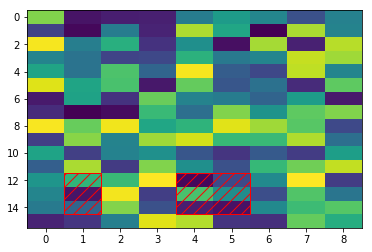

    2017-11-27 15:29:09 | length: 2
    2017-11-27 15:29:09 | parentLength: 3
    2017-11-27 15:29:09 | Scanning children...
    2017-11-27 15:29:09 | Child: 0
      2017-11-27 15:29:09 | Starting recursiveScan...
      2017-11-27 15:29:09 | Direction: 1
      2017-11-27 15:29:09 | Starting scan...
      2017-11-27 15:29:09 | Found start: 1
      2017-11-27 15:29:09 | Found stop: 1
      2017-11-27 15:29:09 | Ending scan...


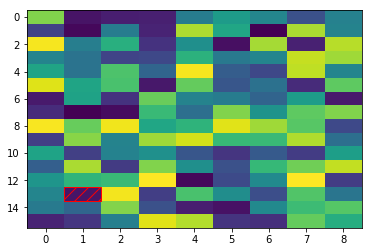

      2017-11-27 15:29:09 | length: 1
      2017-11-27 15:29:09 | parentLength: 2
      2017-11-27 15:29:09 | Scanning children...
      2017-11-27 15:29:09 | Child: 0
        2017-11-27 15:29:09 | Starting recursiveScan...
        2017-11-27 15:29:09 | Direction: 0
        2017-11-27 15:29:09 | Starting scan...
        2017-11-27 15:29:09 | Length is one
        2017-11-27 15:29:09 | Ending scan...


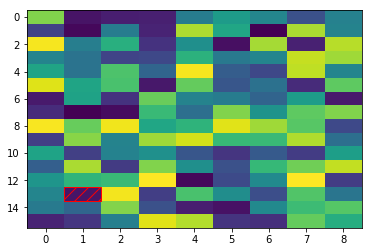

        2017-11-27 15:29:10 | length: 1
        2017-11-27 15:29:10 | parentLength: 1
2017-11-27 15:29:10 | Done: [13, 13, 1, 1]
    2017-11-27 15:29:10 | Child: 1
      2017-11-27 15:29:10 | Starting recursiveScan...
      2017-11-27 15:29:10 | Direction: 1
      2017-11-27 15:29:10 | Starting scan...
      2017-11-27 15:29:10 | Found start: 0
      2017-11-27 15:29:10 | Found stop: 0
      2017-11-27 15:29:10 | Found start: 2
      2017-11-27 15:29:10 | Found stop at end.
      2017-11-27 15:29:10 | Ending scan...


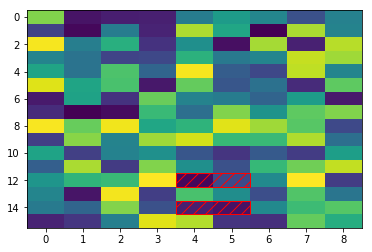

      2017-11-27 15:29:10 | length: 2
      2017-11-27 15:29:10 | parentLength: 2
      2017-11-27 15:29:10 | Scanning children...
      2017-11-27 15:29:10 | Child: 0
        2017-11-27 15:29:10 | Starting recursiveScan...
        2017-11-27 15:29:10 | Direction: 0
        2017-11-27 15:29:10 | Starting scan...
        2017-11-27 15:29:10 | Found start: 0
        2017-11-27 15:29:10 | Found stop: 0
        2017-11-27 15:29:10 | Ending scan...


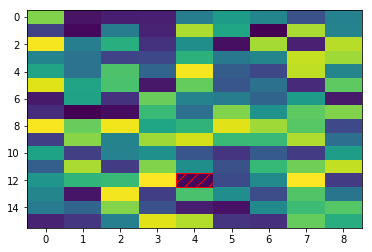

        2017-11-27 15:29:10 | length: 1
        2017-11-27 15:29:10 | parentLength: 2
        2017-11-27 15:29:10 | Scanning children...
        2017-11-27 15:29:10 | Child: 0
          2017-11-27 15:29:10 | Starting recursiveScan...
          2017-11-27 15:29:10 | Direction: 1
          2017-11-27 15:29:10 | Starting scan...
          2017-11-27 15:29:10 | Length is one
          2017-11-27 15:29:10 | Ending scan...


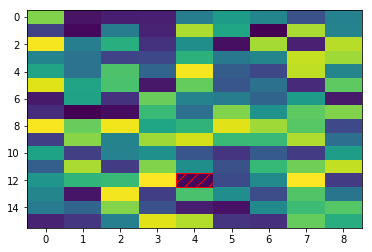

          2017-11-27 15:29:10 | length: 1
          2017-11-27 15:29:10 | parentLength: 1
2017-11-27 15:29:10 | Done: [12, 12, 4, 4]
      2017-11-27 15:29:10 | Child: 1
        2017-11-27 15:29:10 | Starting recursiveScan...
        2017-11-27 15:29:10 | Direction: 0
        2017-11-27 15:29:10 | Starting scan...
        2017-11-27 15:29:10 | Found start: 0
        2017-11-27 15:29:10 | Found stop at end.
        2017-11-27 15:29:10 | Ending scan...


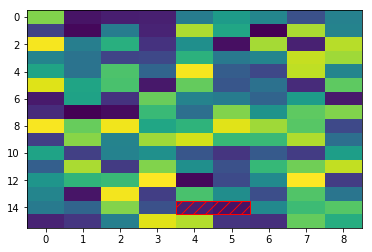

        2017-11-27 15:29:10 | length: 1
        2017-11-27 15:29:10 | parentLength: 2
        2017-11-27 15:29:10 | Scanning children...
        2017-11-27 15:29:10 | Child: 0
          2017-11-27 15:29:10 | Starting recursiveScan...
          2017-11-27 15:29:10 | Direction: 1
          2017-11-27 15:29:10 | Starting scan...
          2017-11-27 15:29:10 | Length is one
          2017-11-27 15:29:10 | Ending scan...


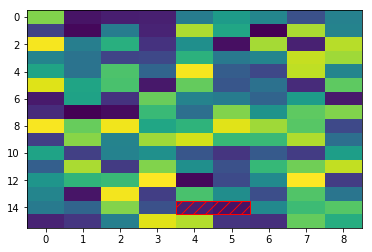

          2017-11-27 15:29:10 | length: 1
          2017-11-27 15:29:10 | parentLength: 1
2017-11-27 15:29:10 | Done: [14, 14, 4, 5]
2017-11-27 15:29:10 | Child: 1
  2017-11-27 15:29:10 | Starting recursiveScan...
  2017-11-27 15:29:10 | Direction: 1
  2017-11-27 15:29:10 | Starting scan...
  2017-11-27 15:29:10 | Found start: 6
  2017-11-27 15:29:10 | Found stop: 6
  2017-11-27 15:29:10 | Ending scan...


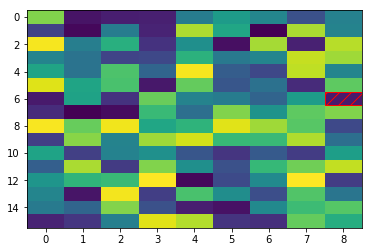

  2017-11-27 15:29:10 | length: 1
  2017-11-27 15:29:10 | parentLength: 2
  2017-11-27 15:29:10 | Scanning children...
  2017-11-27 15:29:10 | Child: 0
    2017-11-27 15:29:10 | Starting recursiveScan...
    2017-11-27 15:29:10 | Direction: 0
    2017-11-27 15:29:10 | Starting scan...
    2017-11-27 15:29:10 | Length is one
    2017-11-27 15:29:10 | Ending scan...


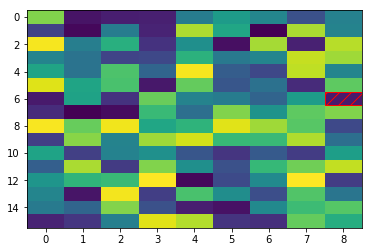

    2017-11-27 15:29:11 | length: 1
    2017-11-27 15:29:11 | parentLength: 1
2017-11-27 15:29:11 | Done: [6, 6, 8, 8]


In [38]:
testBoundariesList = recursiveScan(testDataArray, threshold = 0.1)

In [39]:
testBoundariesList

[[0, 1, 1, 2],
 [1, 2, 5, 6],
 [5, 7, 0, 3],
 [13, 13, 1, 1],
 [12, 12, 4, 4],
 [14, 14, 4, 5],
 [6, 6, 8, 8]]

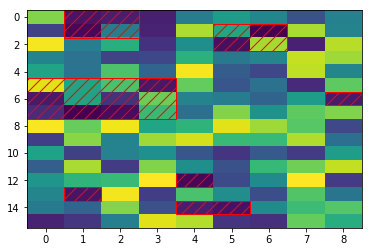

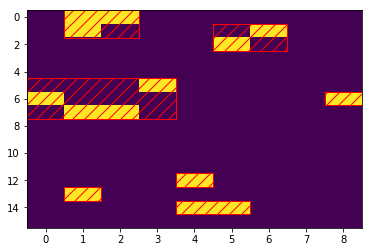

In [40]:
showDataWithBoundaries(testDataArray, testBoundariesList)
showDataWithBoundaries(testDataArray < 0.1, testBoundariesList)

In [41]:
congestionDataArray = numpy.genfromtxt("Congestion.csv", delimiter = ",")

In [42]:
congestionDataArray.shape

(28, 1432)

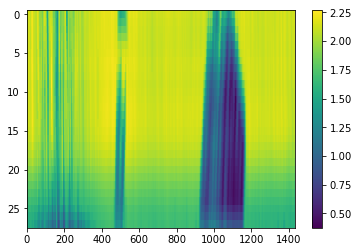

In [43]:
plt.imshow(congestionDataArray, aspect = "auto")
plt.colorbar()
plt.show()

2017-11-27 15:29:46 | Starting recursiveScan...
2017-11-27 15:29:46 | Direction: 0
2017-11-27 15:29:46 | Starting scan...
2017-11-27 15:29:46 | Found start: 166
2017-11-27 15:29:46 | Found stop: 169
2017-11-27 15:29:46 | Found start: 196
2017-11-27 15:29:46 | Found stop: 196
2017-11-27 15:29:46 | Found start: 198
2017-11-27 15:29:46 | Found stop: 199
2017-11-27 15:29:46 | Found start: 936
2017-11-27 15:29:46 | Found stop: 989
2017-11-27 15:29:46 | Found start: 1011
2017-11-27 15:29:46 | Found stop: 1160
2017-11-27 15:29:46 | Ending scan...


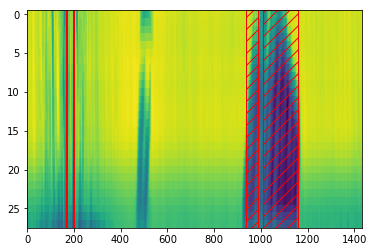

2017-11-27 15:29:46 | length: 5
2017-11-27 15:29:46 | parentLength: 0
2017-11-27 15:29:46 | Scanning children...
2017-11-27 15:29:46 | Child: 0
  2017-11-27 15:29:46 | Starting recursiveScan...
  2017-11-27 15:29:46 | Direction: 1
  2017-11-27 15:29:46 | Starting scan...
  2017-11-27 15:29:46 | Found start: 26
  2017-11-27 15:29:46 | Found stop at end.
  2017-11-27 15:29:46 | Ending scan...


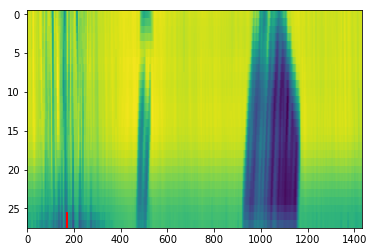

  2017-11-27 15:29:46 | length: 1
  2017-11-27 15:29:46 | parentLength: 5
  2017-11-27 15:29:46 | Scanning children...
  2017-11-27 15:29:46 | Child: 0
    2017-11-27 15:29:46 | Starting recursiveScan...
    2017-11-27 15:29:46 | Direction: 0
    2017-11-27 15:29:46 | Starting scan...
    2017-11-27 15:29:46 | Found start: 0
    2017-11-27 15:29:46 | Found stop at end.
    2017-11-27 15:29:46 | Ending scan...


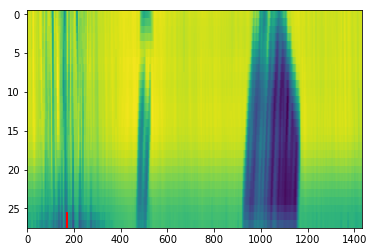

    2017-11-27 15:29:46 | length: 1
    2017-11-27 15:29:46 | parentLength: 1
2017-11-27 15:29:46 | Done: [26, 27, 166, 169]
2017-11-27 15:29:46 | Child: 1
  2017-11-27 15:29:46 | Starting recursiveScan...
  2017-11-27 15:29:46 | Direction: 1
  2017-11-27 15:29:46 | Starting scan...
  2017-11-27 15:29:46 | Found start: 27
  2017-11-27 15:29:46 | Found stop at end.
  2017-11-27 15:29:46 | Ending scan...


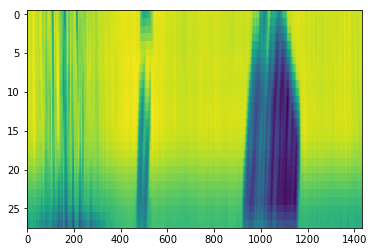

  2017-11-27 15:29:47 | length: 1
  2017-11-27 15:29:47 | parentLength: 5
  2017-11-27 15:29:47 | Scanning children...
  2017-11-27 15:29:47 | Child: 0
    2017-11-27 15:29:47 | Starting recursiveScan...
    2017-11-27 15:29:47 | Direction: 0
    2017-11-27 15:29:47 | Starting scan...
    2017-11-27 15:29:47 | Length is one
    2017-11-27 15:29:47 | Ending scan...


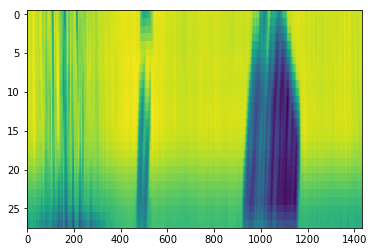

    2017-11-27 15:29:47 | length: 1
    2017-11-27 15:29:47 | parentLength: 1
2017-11-27 15:29:47 | Done: [27, 27, 196, 196]
2017-11-27 15:29:47 | Child: 2
  2017-11-27 15:29:47 | Starting recursiveScan...
  2017-11-27 15:29:47 | Direction: 1
  2017-11-27 15:29:47 | Starting scan...
  2017-11-27 15:29:47 | Found start: 27
  2017-11-27 15:29:47 | Found stop at end.
  2017-11-27 15:29:47 | Ending scan...


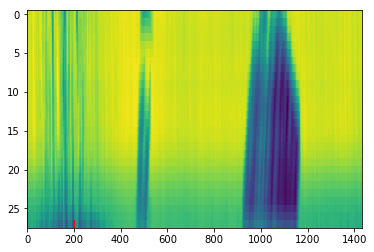

  2017-11-27 15:29:47 | length: 1
  2017-11-27 15:29:47 | parentLength: 5
  2017-11-27 15:29:47 | Scanning children...
  2017-11-27 15:29:47 | Child: 0
    2017-11-27 15:29:47 | Starting recursiveScan...
    2017-11-27 15:29:47 | Direction: 0
    2017-11-27 15:29:47 | Starting scan...
    2017-11-27 15:29:47 | Found start: 0
    2017-11-27 15:29:47 | Found stop at end.
    2017-11-27 15:29:47 | Ending scan...


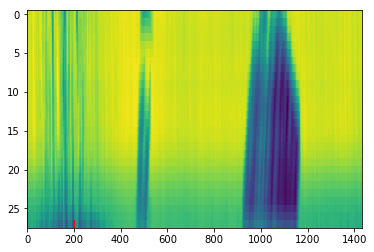

    2017-11-27 15:29:47 | length: 1
    2017-11-27 15:29:47 | parentLength: 1
2017-11-27 15:29:47 | Done: [27, 27, 198, 199]
2017-11-27 15:29:47 | Child: 3
  2017-11-27 15:29:47 | Starting recursiveScan...
  2017-11-27 15:29:47 | Direction: 1
  2017-11-27 15:29:47 | Starting scan...
  2017-11-27 15:29:47 | Found start: 10
  2017-11-27 15:29:47 | Found stop: 26
  2017-11-27 15:29:47 | Ending scan...


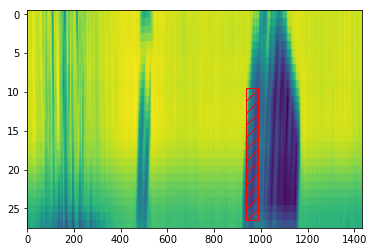

  2017-11-27 15:29:47 | length: 1
  2017-11-27 15:29:47 | parentLength: 5
  2017-11-27 15:29:47 | Scanning children...
  2017-11-27 15:29:47 | Child: 0
    2017-11-27 15:29:47 | Starting recursiveScan...
    2017-11-27 15:29:47 | Direction: 0
    2017-11-27 15:29:47 | Starting scan...
    2017-11-27 15:29:47 | Found start: 0
    2017-11-27 15:29:47 | Found stop at end.
    2017-11-27 15:29:47 | Ending scan...


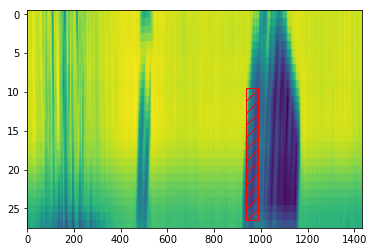

    2017-11-27 15:29:47 | length: 1
    2017-11-27 15:29:47 | parentLength: 1
2017-11-27 15:29:47 | Done: [10, 26, 936, 989]
2017-11-27 15:29:47 | Child: 4
  2017-11-27 15:29:47 | Starting recursiveScan...
  2017-11-27 15:29:47 | Direction: 1
  2017-11-27 15:29:47 | Starting scan...
  2017-11-27 15:29:47 | Found start: 3
  2017-11-27 15:29:47 | Found stop at end.
  2017-11-27 15:29:47 | Ending scan...


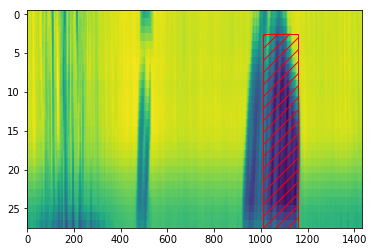

  2017-11-27 15:29:47 | length: 1
  2017-11-27 15:29:47 | parentLength: 5
  2017-11-27 15:29:47 | Scanning children...
  2017-11-27 15:29:47 | Child: 0
    2017-11-27 15:29:47 | Starting recursiveScan...
    2017-11-27 15:29:47 | Direction: 0
    2017-11-27 15:29:47 | Starting scan...
    2017-11-27 15:29:47 | Found start: 0
    2017-11-27 15:29:47 | Found stop at end.
    2017-11-27 15:29:47 | Ending scan...


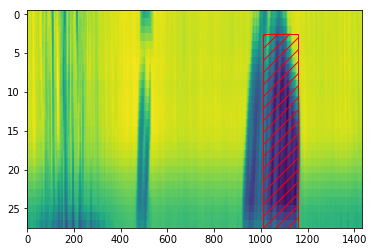

    2017-11-27 15:29:48 | length: 1
    2017-11-27 15:29:48 | parentLength: 1
2017-11-27 15:29:48 | Done: [3, 27, 1011, 1160]


In [48]:
congestionBoundariesList = recursiveScan(congestionDataArray, threshold = 0.9)

In [50]:
congestionBoundariesList

[[26, 27, 166, 169],
 [27, 27, 196, 196],
 [27, 27, 198, 199],
 [10, 26, 936, 989],
 [3, 27, 1011, 1160]]

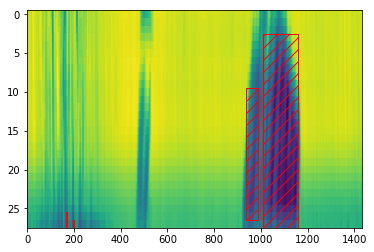

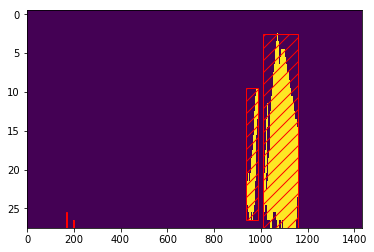

In [49]:
showDataWithBoundaries(congestionDataArray, congestionBoundariesList)
showDataWithBoundaries(congestionDataArray < 0.9, congestionBoundariesList)

End of Notebook